In [27]:
!pip install super_gradients

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 60.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 107.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 9.9 MB/s

In [20]:
!pip install -U onnxruntime-gpu==1.12.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 MB 3.8 MB/s eta 0:00:00


In [21]:
!git clone https://github.com/imneonizer/yolo-nas-retail-training.git

Cloning into 'yolo-nas-retail-training'...
remote: Enumerating objects: 18, done.
remote: Total 18 (delta 0), reused 0 (delta 0), pack-reused 18
Receiving objects: 100% (18/18), 52.23 MiB | 14.35 MiB/s, done.


In [1]:
cd /content/yolo-nas-retail-training

/content/yolo-nas-retail-training


In [3]:
import cv2
import glob
import torch
import numpy as np
from PIL import Image
from super_gradients.training import models

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CLASSES = ['product']
CLASSES += [str(i) for i in range(80 - len(CLASSES))]



[2024-03-25 09:33:29] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2024-03-25 09:33:29] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-03-25 09:33:34] INFO - utils.py - NumExpr defaulting to 2 threads.
[2024-03-25 09:33:36] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-03-25 09:33:36] WARNING - export.py - Failed to import pytorch_quantization
[2024-03-25 09:33:36] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [4]:
from yolo_nas_onnx.models import load_net
from yolo_nas_onnx.processing import Preprocessing, Postprocessing
from yolo_nas_onnx.draw import draw_box
from yolo_nas_onnx.utils import Labels

In [6]:
prep_steps = [
    {"DetLongMaxRescale": None},
    {"BotRightPad": {"pad_value": 114}}
]

iou_thres = 0.65
score_thres = 0.5
labels = ["0"]

_, _, input_height, input_width = net.input_shape  # get input height and width [b, c, h, w]

pre_process = Preprocessing(
    prep_steps, (input_height, input_width)
)

post_process = Postprocessing(
    prep_steps,
    iou_thres,
    score_thres,
)

labels = Labels(labels)

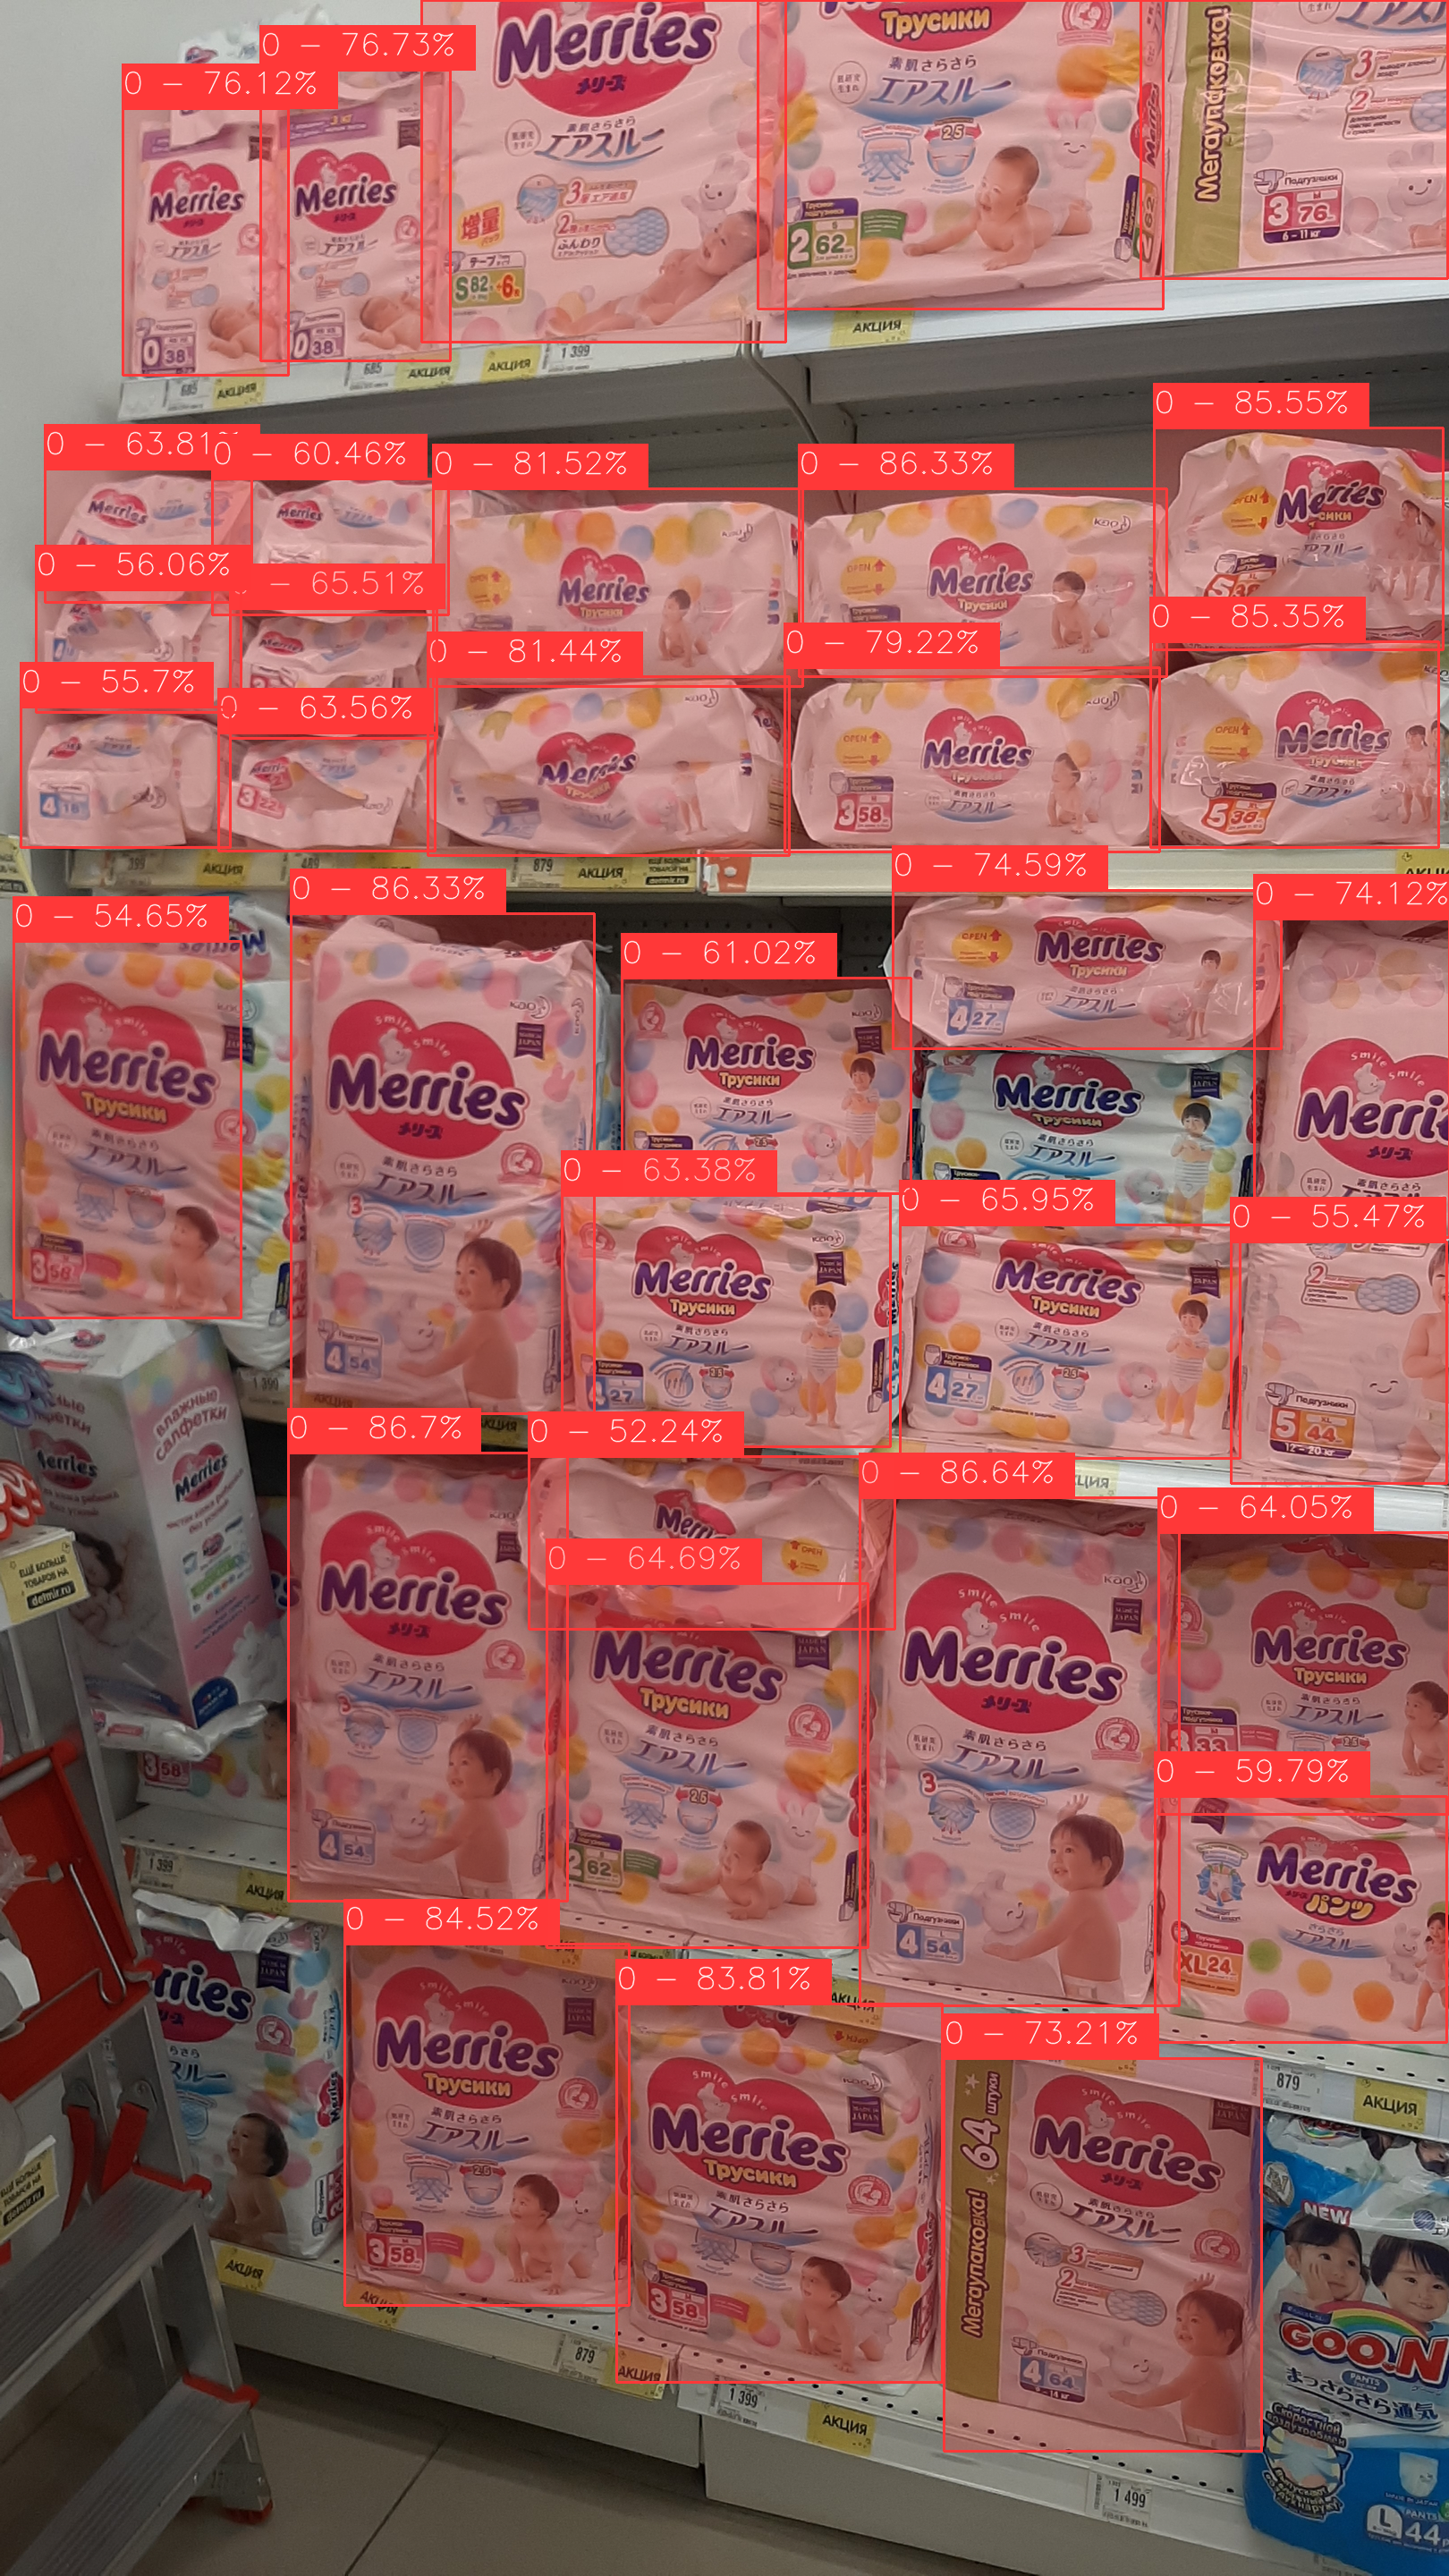

In [7]:
import cv2
import numpy as np
from PIL import Image

img = cv2.imread("/content/Product-grouping-retail/images/Vitaly.Okhonya_2020_11_26_10_34_25_1606376065436.jpg")
img = detect(net, img, pre_process, post_process, labels)

Image.fromarray(img[:,:,::-1])

In [8]:
import cv2
import numpy as np

# Assuming `detect()` function is defined elsewhere in your code
# Also, make sure the `net`, `pre_process`, `post_process`, and `labels` are defined

img = cv2.imread("/content/Product-grouping-retail/images/Vitaly.Okhonya_2020_11_26_10_33_27_1606376007516.jpg")
img = detect(net, img, pre_process, post_process, labels)

cv2.imwrite("output_image.jpg", img)


True

In [32]:
import cv2
import numpy as np


def detect(net, source, pre_process, post_process, labels):
    net_input = source.copy()  # copy source array
    input_, prep_meta = pre_process(net_input)  # run preprocess
    outputs = net.forward(input_)  # forward

    boxes, scores, classes = post_process(outputs, prep_meta)  # postprocess output
    selected = cv2.dnn.NMSBoxes(
        boxes, scores, post_process.score_thres, post_process.iou_thres
    )  # run nms to filter boxes

    for i in selected:  # loop through selected idx
        box_int = boxes[i, :].astype(int)
        x1, y1, width, height = box_int
        print(box_int)
        cropped_image = source[y1:y1+height, x1:x1+width]


        cv2.imwrite(f'product/Cropped_Image_{i}.png', cropped_image)

        score = float(scores[i]) * 100  # percentage score
        label, color = labels(classes[i], use_bgr=True)  # get label and color class_id

        # draw boxes
        draw_box(source, box_int, label, score, color)

    return source  # Image array after draw process


# Assuming `detect()` function is defined elsewhere in your code
# Also, make sure the `net`, `pre_process`, `post_process`, and `labels` are defined

img = cv2.imread("/content/Product-grouping-retail/images/Vitaly.Okhonya_2020_11_26_10_33_27_1606376007516.jpg")
img = detect(net, img, pre_process, post_process, labels)

cv2.imwrite("output_image.jpg", img)


[1243 1053  314  225]
[ 974 1336  300  218]
[627 764 306 225]
[ 652 1336  311  220]
[1245  757  309  224]
[1263 1332  309  227]
[1264 2056  253  181]
[ 366 1082  288  200]
[ 930 1053  320  226]
[942 758 312 227]
[1244 1748  253  159]
[ 983 1753  265  155]
[313 775 296 211]
[  67 1077  305  208]
[1246  441  308  245]
[ 530 1759  228  154]
[ 40 777 285 211]
[ 747 1590  241  173]
[ 751 1756  236  152]
[ 791 2101  225  148]
[ 985 1595  262  165]
[946 452 302 234]
[ 346 1352  287  204]
[  65 1354  291  206]
[ 526 1601  232  163]
[ 663 1088  236  191]
[1245 1601  250  152]
[ 573 1963  226  155]
[ 798 1959  222  149]
[1017 2034  257  208]
[ 545 2295  226  172]
[ 40 488 278 197]
[ 764 2295  224  172]
[326 489 282 196]
[634 450 306 239]
[ 761 2464  222  148]
[ 306 1767  235  146]
[ 562 2110  236  141]
[  91 1969  235  151]
[ 325 2293  225  166]
[ 320 2106  230  147]
[ 320 1958  235  156]
[ 302 1605  231  162]
[ 114 2290  217  159]
[ 101 2113  223  138]
[ 328 2457  221  153]
[  78 1609  229  162

True

In [30]:
import cv2

# Load the image
image_path = "/content/Product-grouping-retail/images/Vitaly.Okhonya_2020_11_26_10_33_27_1606376007516.jpg"
image = cv2.imread(image_path)

# Bounding box coordinates [x1, y1, width, height]
x1, y1, width, height = [1243, 1053, 314, 225]

# Crop the image using slicing
cropped_image = image[y1:y1+height, x1:x1+width]

# Save the cropped image
cv2.imwrite("cropped_image.jpg", cropped_image)


True